<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-решающего-леса" data-toc-modified-id="Модель-решающего-леса-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель решающего леса</a></span></li><li><span><a href="#Модель-LightGBM" data-toc-modified-id="Модель-LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель LightGBM</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Заключение</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<b>Задача: построить модель для прогнозирования количества заказов такси на следующий час в период пиковой нагрузки. </b>

## Подготовка

Сначала отдельно импортируем все необходимые библиотеки и функции:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

Далее откроем и изучим файлы с данными, сразу импортировав их как временной ряд:

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Анализ

У нас есть только исторические данные о времени заказов такси и их количестве. Пропуски в таблице отсутствуют.

Проверим, в хронологическом ли порядке расположены даты и время в индексе:

In [3]:
print(df.index.is_monotonic)

True


С этим всё в порядке.

Далее выполним ресемплирование данных по одному часу, а затем проверим сезонность за неделю - циклично повторяющиеся закономерности в нашем временном ряду:

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


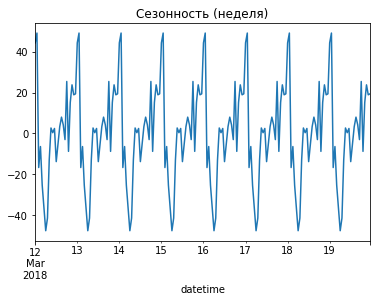

Text(0.5, 1.0, 'Тренд (неделя)')

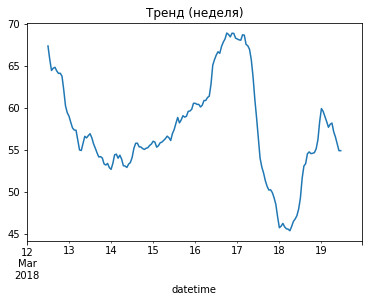

In [4]:
df = df.resample('1H').sum()
display(df.head())
seasonal_decompose(df['2018-03-12':'2018-03-19']).seasonal.plot()
plt.title('Сезонность (неделя)')
plt.show()
seasonal_decompose(df['2018-03-12':'2018-03-19']).trend.plot()
plt.title('Тренд (неделя)')

Общий график временного ряда выглядит так:

<AxesSubplot:xlabel='datetime'>

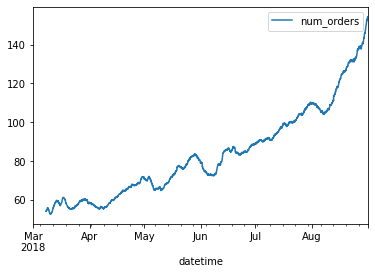

In [5]:
df.rolling(168).mean().plot()

График сезонности в течение дня:

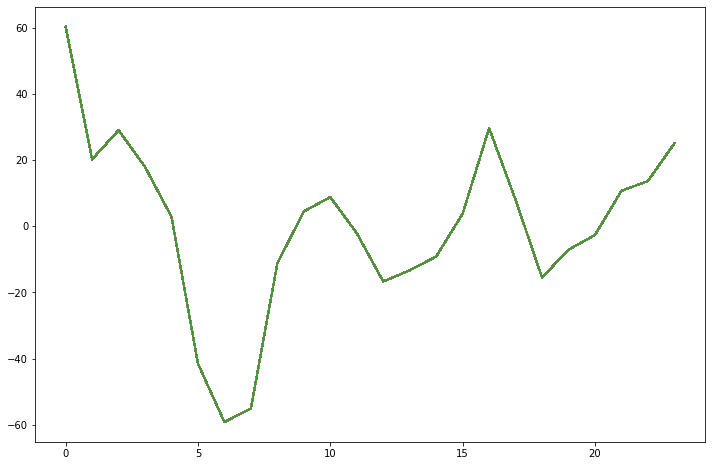

In [6]:
fig = plt.figure(figsize=(12, 8))
counter = 24
decomposed_by_day = seasonal_decompose(df).seasonal
while counter < decomposed_by_day.shape[0]:
    plt.plot(decomposed_by_day[counter-24:counter].reset_index(drop=True), figure=fig)
    counter += 24

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df, 24, 72)
df

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,162.861111
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,163.208333
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,164.041667


## Обучение

Признаки готовы, теперь делим данные на тестовую и тренировочную выборки, оставив для тестовой выборки лишь 10% ото всех данных. Затем удалим в тестовой выборке пустые строки, образовавшиеся в процессе создания новых признаков:

In [8]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_train

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-04 00:00:00,4,6,43.0,63.0,48.0,83.0,30.0,68.0,49.0,46.0,...,56.0,17.0,9.0,15.0,44.0,64.0,25.0,108.0,163.0,57.777778
2018-03-04 01:00:00,4,6,75.0,43.0,63.0,48.0,83.0,30.0,68.0,49.0,...,73.0,56.0,17.0,9.0,15.0,44.0,64.0,25.0,108.0,57.097222
2018-03-04 02:00:00,4,6,60.0,75.0,43.0,63.0,48.0,83.0,30.0,68.0,...,52.0,73.0,56.0,17.0,9.0,15.0,44.0,64.0,25.0,56.750000
2018-03-04 03:00:00,4,6,26.0,60.0,75.0,43.0,63.0,48.0,83.0,30.0,...,57.0,52.0,73.0,56.0,17.0,9.0,15.0,44.0,64.0,56.125000
2018-03-04 04:00:00,4,6,42.0,26.0,60.0,75.0,43.0,63.0,48.0,83.0,...,32.0,57.0,52.0,73.0,56.0,17.0,9.0,15.0,44.0,55.791667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,13,0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,...,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0,123.680556
2018-08-13 10:00:00,13,0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,...,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,124.458333
2018-08-13 11:00:00,13,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,124.500000


Теперь построим несколько разных моделей с различными гиперпараметрами для получения наилучшего результата:

### Модель решающего леса

In [9]:
%%time

parameters = { 'n_estimators': range (20, 51, 10),
              'max_depth': range (4, 12, 2) }
clf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(clf, parameters, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
print(grid.best_params_)
print('Лучшее значение RMSE:', abs(grid.best_score_)**0.5)

{'max_depth': 10, 'n_estimators': 50}
Лучшее значение RMSE: 26.294956159662252
CPU times: user 35.6 s, sys: 122 ms, total: 35.7 s
Wall time: 35.7 s


Используем найденные параметры для обучения нашей модели:

In [10]:
%%time

best_forest_model = RandomForestRegressor(random_state=9428, max_depth=10, n_estimators=40)
best_forest_model.fit(features_train, target_train)

CPU times: user 1.27 s, sys: 7.83 ms, total: 1.28 s
Wall time: 1.29 s


RandomForestRegressor(max_depth=10, n_estimators=40, random_state=9428)

### Модель LightGBM

In [11]:
%%time

parameters = { 'n_estimators': range (10, 41, 10),
              'learning_rate': [0.3, 0.4, 0.5, 0.6] }
clf = lgb.LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(clf, parameters, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
print(grid.best_params_)
print('Лучшее значение RMSE:', abs(grid.best_score_)**0.5)

{'learning_rate': 0.3, 'n_estimators': 20}
Лучшее значение RMSE: 26.80830448567736
CPU times: user 54.2 s, sys: 523 ms, total: 54.7 s
Wall time: 55.1 s


Используем эти параметры learning_rate' = 0.3 и 'n_estimators' = 12 для обучения модели:

In [12]:
%%time

gbm = lgb.LGBMRegressor(objective='regression', learning_rate=0.3, n_estimators=12)
gbm.fit(features_train, target_train, eval_set=[(features_test, target_test)], eval_metric='l1')

[1]	valid_0's l1: 56.4142	valid_0's l2: 5226.05
[2]	valid_0's l1: 48.2984	valid_0's l2: 4017.7
[3]	valid_0's l1: 42.5621	valid_0's l2: 3235.58
[4]	valid_0's l1: 39.5803	valid_0's l2: 2868.99
[5]	valid_0's l1: 37.6507	valid_0's l2: 2606.79
[6]	valid_0's l1: 36.7995	valid_0's l2: 2487.91
[7]	valid_0's l1: 35.6558	valid_0's l2: 2349.91
[8]	valid_0's l1: 35.1872	valid_0's l2: 2286.33
[9]	valid_0's l1: 34.5123	valid_0's l2: 2191.07
[10]	valid_0's l1: 33.9167	valid_0's l2: 2113.89
[11]	valid_0's l1: 33.773	valid_0's l2: 2087.29
[12]	valid_0's l1: 33.0882	valid_0's l2: 2011.98
CPU times: user 281 ms, sys: 14.6 ms, total: 296 ms
Wall time: 303 ms


LGBMRegressor(learning_rate=0.3, n_estimators=12, objective='regression')

### Модель CatBoost

In [13]:
%%time

parameters = { 'learning_rate': [0.2, 0.4],
              'depth': [4, 6, 10],
              'n_estimators': [200],
              'verbose': [False]
             }
clf = CatBoostRegressor()
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(clf, parameters, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
print(grid.best_params_)
print('Лучшее значение RMSE:', abs(grid.best_score_)**0.5)

{'depth': 6, 'learning_rate': 0.2, 'n_estimators': 200, 'verbose': False}
Лучшее значение RMSE: 25.390252032084188
CPU times: user 1min 30s, sys: 957 ms, total: 1min 31s
Wall time: 1min 45s


Используем эти параметры learning_rate' = 0.2, depth = 4 и n_estimators = 200 для обучения модели:

In [14]:
%%time

cat = CatBoostRegressor(learning_rate=0.2, depth=6, n_estimators=200)
cat.fit(features_train, target_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 1.13 s, sys: 43.4 ms, total: 1.17 s
Wall time: 1.67 s


## Тестирование

Самой быстрой и качественной моделью оказалась модель CatBoost со временем обучения около 2 секунд и значением RMSE - 25.39.

Теперь проверим её на тестовой выборке:

In [15]:
%%time

predict_test = cat.predict(features_test)
print('The rmse of prediction is:', mean_squared_error(target_test, predict_test, squared=False))

The rmse of prediction is: 41.69440968949513
CPU times: user 323 µs, sys: 3.81 ms, total: 4.13 ms
Wall time: 2.79 ms


Значение метрики RMSE на тестовой выборке составило 41.7. Это менее 48, а значит согласно нашему заданию нам удалось успешно построить модель для прогнозирования количества заказов такси на следующий час в период пиковой нагрузки.

Также дополнительно можно сравнить реальные данные с фактическим прогнозом:

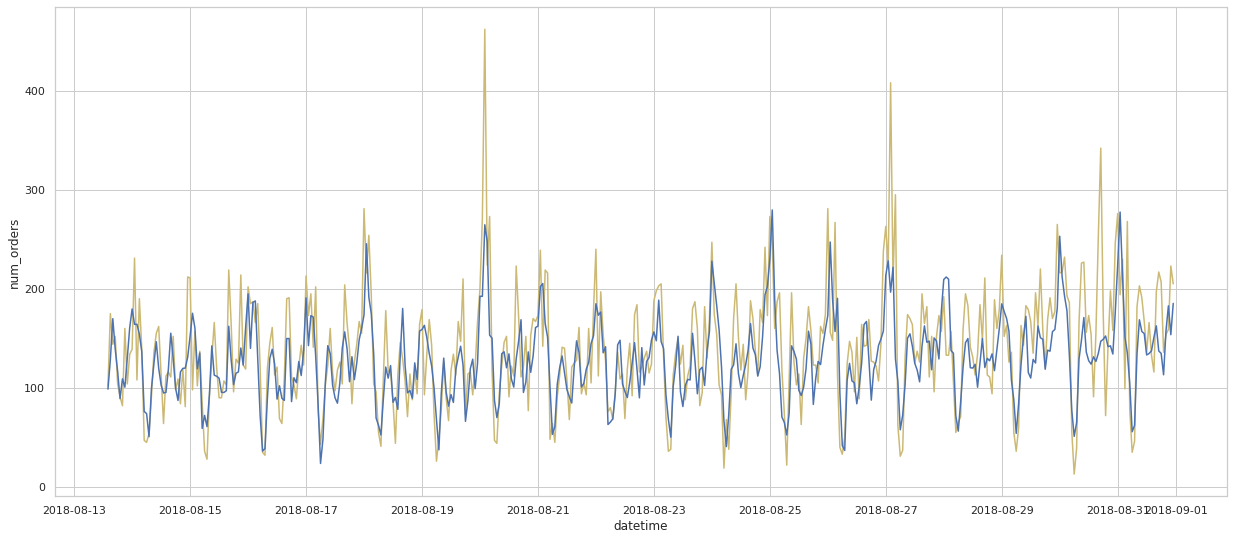

In [16]:
def real_pred_plot(real, pred):
    pred_series = pd.Series(data=pred[:len(real)], index=real.index)
    sns.set(style='whitegrid')
    fig, ax = plt.subplots(figsize=(21,9))
    sns.lineplot(x=real.index, y=real, ax=ax, color='y')
    sns.lineplot(x=pred_series.index, y=pred_series, ax=ax, color='b')

real_pred_plot(target_test, predict_test)

Из графика видим, что предсказаное значение в среднем повторяет цель, отставая в экстремумах. Очевидно, стоит ещё поработать с признаками, чтобы отыскать эту составляющую. Возможно, имеет смысл подмешать данные более мелкого 10-минутного масштаба.

## Заключение

Подведём итог.

Мы провели исследование временного ряда на предмет трендовых и сезонных закономерностей, случайной составляющей. Выяснили, что ряд имеет следующие характеристики:
1. Есть общий тренд, он растущий и мультипликативный, более чем 2-го порядка.
2. Присутствуют как минимум две сезонности: недельная и 24-часовая.
3. Достаточно велика случайная составляющая, что является теоретическим пределом для качества модели.

Есть ли возможности для улучшения точности модели? На мой взгляд, да. Следут поэкспериментировать с признаками. Например:
- Подмешать данные более старшего временного масштаба - 1 день
- Подмешать данные более мелкого масштаба - 10 минут
- Добавить скользящие средние по этим данным
- Добавить куб номера наблюдения.

Так же исследовать значимость признаков. Это вопрос, который мы здесь не рассматривали вовсе.

И ещё один момент - при эксплуатации предусмотреть переобучение модели каждую неделю. Характеристики временных рядов постепенно уходят. Модель должна следить за этим.